In [43]:
import torch

from utils import DEVICE, init_random_seeds
from models._utils import (
    print_parameters,
    NaivePredictor,
    LinearRegression,
    FeatureFFNN,
    PureAttention,
    NeuralTransformer,
    NetworkLSTM,
    NetworkCTRNN,
    LiquidCfC,
)

# from fvcore.nn import (
#     FlopCountAnalysis,
#     ActivationCountAnalysis,
#     flop_count_table,
#     flop_count_str,
# )


# Initialize the random seeds
init_random_seeds(42)

In [44]:
# @title Prepare model and input
# @markdown Make sure the model and input are on the same device.

# Set shapes for model and input
seq_len = 100
input_size = 302
hidden_size = 300

# Use a standard PyTorch model
model = torch.nn.Linear(in_features=input_size, out_features=hidden_size)
model = model.to(DEVICE)
model.eval()  # switch to eval mode
print(f"Simple PyTorch model: {model}\n")

# Create input of the correct shape for the model
input = torch.randn(1, seq_len, input_size).to(DEVICE)  # batch_size=1
mask = None
print(f"Input: {input.shape} \t Output: {model(input).shape}", end="\n\n")
print(f"\n{'~'*100}\n")

# Load one of our custom models instead
model_args = dict(input_size=input_size, hidden_size=hidden_size, loss="MSE")
# model = NaivePredictor(**model_args)
# model = LinearRegression(**model_args)
# model = FeatureFFNN(**model_args)  # hidden_size = 516 -> num_params = 580286
# model = PureAttention(**model_args)  # hidden_size = 312 -> num_params = 580310
# model = NeuralTransformer(**model_args)  # hidden_size = 196 -> num_params = 584186
# model = NetworkLSTM(**model_args)  # hidden_size = 234 -> num_params = 582260
model = NetworkCTRNN(**model_args)  # hidden_size = 408 -> num_params = 582110
# model = LiquidCfC(**model_args)  # hidden_size = 422 -> num_params = 582368
model = model.to(DEVICE)
model.eval()  # switch to eval mode
print(f"Custom model: {model}\n")

# Create input of the correct shape for the model
input = torch.randn(1, seq_len, input_size).to(DEVICE)  # batch_size=1
mask = torch.ones(1, input_size).to(bool).to(DEVICE)
print(
    f"Input: {input.shape} \t Mask: {mask.shape} \t Output: {model(input, mask).shape}",
    end="\n\n",
)

Simple PyTorch model: Linear(in_features=302, out_features=300, bias=True)

Input: torch.Size([1, 100, 302]) 	 Output: torch.Size([1, 100, 300])


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Custom model: NetworkCTRNN(
  (identity): Identity()
  (input_hidden): Sequential(
    (0): Linear(in_features=302, out_features=300, bias=True)
    (1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
  )
  (hidden_hidden): CTRNN(
    (input2h): Linear(in_features=300, out_features=300, bias=True)
    (h2h): Linear(in_features=300, out_features=300, bias=True)
  )
  (inner_hidden_model): InnerHiddenModel(
    (hidden_hidden): CTRNN(
      (input2h): Linear(in_features=300, out_features=300, bias=True)
      (h2h): Linear(in_features=300, out_features=300, bias=True)
    )
  )
  (latent_embedding): Linear(in_features=302, out_features=300, bias=True)
  (linear): Linear(in_features=300, out_features=302, bias=True)
  (layer_norm): Layer

In [45]:
# @title Using fvcore

# Adjust input based on if we use standard PyTorch model or custom model
input = (input, mask) if mask is not None else input

# Count the total and number of trainable parameters
all_params_ct, train_params_ct = print_parameters(model)

print(f"\nAll params: {all_params_ct}\nTrainable params: {train_params_ct}", end="\n\n")

### DEBUG: Find way to compute FLOP using Pytorch Profiler ###

# # Perform FLOP Counting: Use the FlopCountAnalysis class to analyze your model:
# flops = FlopCountAnalysis(model, input)

# # Print Results: You can now print out the FLOP and parameter information:
# print(
#     f"FLOP: {flops.total(), flops.by_operator(), flops.by_module(), flops.by_module_and_operator()}",
#     end="\n\n",
# )
# print(flop_count_str(flops), end="\n\n")
# print(flop_count_table(flops), end="\n\n")
# print(
#     f"\tParams: {sum(p.numel() for p in model.parameters() if p.requires_grad)}",
#     end="\n\n",
# )

# # Perform Activations Counting: Use the ActivationCountAnalysis class to analyze your model:
# acts = ActivationCountAnalysis(model, input)

# # Print Results: You can now print out the FLOP and parameter information:
# print(
#     f"Activations: {acts.total(), acts.by_operator(), acts.by_module(), acts.by_module_and_operator()}",
#     end="\n\n",
# )
# print(
#     f"\tParams: {sum(p.numel() for p in model.parameters() if p.requires_grad)}",
#     end="\n\n",
# )

### DEBUG: Find way to compute FLOP using Pytorch Profiler ###


All params: 363302
Trainable params: 363302



[Identity(), Sequential(
  (0): Linear(in_features=302, out_features=300, bias=True)
  (1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
), CTRNN(
  (input2h): Linear(in_features=300, out_features=300, bias=True)
  (h2h): Linear(in_features=300, out_features=300, bias=True)
), InnerHiddenModel(
  (hidden_hidden): CTRNN(
    (input2h): Linear(in_features=300, out_features=300, bias=True)
    (h2h): Linear(in_features=300, out_features=300, bias=True)
  )
), Linear(in_features=302, out_features=300, bias=True), Linear(in_features=300, out_features=302, bias=True), LayerNorm((300,), eps=1e-05, elementwise_affine=True)]


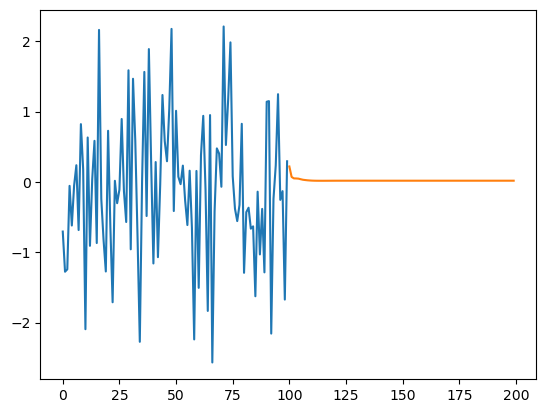

In [46]:
### DEBUG ###

print(list(model.children()))
input, mask = input

import matplotlib.pyplot as plt
import numpy as np

_ = 100
genout = model.generate(input, mask, _)

plt.plot(np.arange(input.shape[1]), input.squeeze().cpu().numpy()[:, 0])
plt.plot(np.arange(input.shape[1], input.shape[1] + _), genout.squeeze().cpu().numpy()[:, 0])

### DEBUG ###